In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from constants import *

In [2]:
rruff_db = pd.read_csv('rruff_database_2021_12_25.csv',
                           index_col='Mineral Name',
                           dtype=str,
                           na_filter=False
                          ).transpose()

In [3]:
stages = [ '0', '1', '2', '3a', '3b', '4a', '4b', '5', '7', '10a', '10b' ]
rruff_db_stages = {
    s: pd.read_csv(f'rruff_database_2021_12_25_S{s}.csv',
                       index_col='Mineral Name',
                       dtype=str,
                       na_filter=False
                      ).transpose()
    for s in stages
}
            
# determine all the minerals present in each stage
minerals_present_in_stage = {
    stage: [ mineral for mineral in rruff_db_stages[stage].keys() ]
    for stage in stages
}

# determine which stage a mineral first appeared in
stages_where_minerals_first_appeared = {}
for mineral in rruff_db.keys():
    for stage in stages:
        if mineral in rruff_db_stages[stage].keys():
            stages_where_minerals_first_appeared[mineral] = stage
            break

# determine all the minerals that first appeared in each stage
minerals_first_appeared_in_stage = {
    stage: [ mineral for mineral, stg in stages_where_minerals_first_appeared.items() if stg == stage ]
    for stage in stages
}

In [4]:
symmetry_indices = {
    'amorphous': 0,
    'triclinic': 1,
    'monoclinic': 2,
    'orthorhombic': 3,
    'trigonal': 4,
    'tetragonal': 5,
    'hexagonal': 6,
    'cubic': 7
}

first_upper = lambda s: ''.join([s[0].upper(), s[1:]])

no_crystal_system = ''
# calculate the symmetry index of each stage based on the minerals that first appeared in each stage
stage_symmetry_indices_appeared = []
stage_species_appeared_populations = []
for stage, minerals_appeared in minerals_first_appeared_in_stage.items():
    stage_symmetry_index = 0
    stage_population = { crystal_system: 0 for crystal_system in symmetry_indices.keys() }
    num_minerals = 0
    for mineral in minerals_appeared:
        crystal_systems = rruff_db_stages[stage][mineral]['Crystal Systems']
        for crystal_system in crystal_systems.replace(', ', '|').split('|'):
            if crystal_system in symmetry_indices.keys():
                stage_symmetry_index += symmetry_indices[crystal_system]
                stage_population[crystal_system] += 1
                num_minerals += 1
            else:
                no_crystal_system += f'S{stage} - {mineral}: {crystal_system}\n'
                
    stage_symmetry_indices_appeared.append(
        stage_symmetry_index / symmetry_indices['cubic'] / num_minerals
    )
    stage_species_appeared_populations.append(stage_population)
            
n_minerals_appeared_in_stage = [ sum(stage_pop.values()) for stage_pop in stage_species_appeared_populations ]
stage_species_appeared_populations = pd.DataFrame(stage_species_appeared_populations)
stage_species_appeared_populations.index = stages
stage_species_appeared_populations_pct = (
    stage_species_appeared_populations.transpose()/n_minerals_appeared_in_stage*100
).transpose()
stage_species_appeared_populations['total'] = n_minerals_appeared_in_stage

stage_species_appeared_populations.rename(first_upper, axis='columns', inplace=True)
stage_species_appeared_populations_pct.rename(first_upper, axis='columns', inplace=True)

with open('no_crystal_system.txt', 'w') as f:
    f.write(no_crystal_system)
    
# calculate the symmetry index of each stage based on the minerals present in each stage
stage_symmetry_indices_present = []
stage_species_present_populations = []
for stage, minerals_present in minerals_present_in_stage.items():
    stage_symmetry_index = 0
    stage_population = { crystal_system: 0 for crystal_system in symmetry_indices.keys() }
    for mineral in minerals_present:
        crystal_systems = rruff_db_stages[stage][mineral]['Crystal Systems']
        for crystal_system in crystal_systems.replace(', ', '|').split('|'):
            if crystal_system in symmetry_indices.keys():
                stage_symmetry_index += symmetry_indices[crystal_system]
                stage_population[crystal_system] += 1
                
    stage_symmetry_indices_present.append(
        stage_symmetry_index / symmetry_indices['cubic'] / len(minerals_present)
    )
    stage_species_present_populations.append(stage_population)
    
n_minerals_present_in_stage = [ sum(stage_pop.values()) for stage_pop in stage_species_present_populations ]
stage_species_present_populations = pd.DataFrame(stage_species_present_populations)
stage_species_present_populations.index = stages
stage_species_present_populations_pct = (
    stage_species_present_populations.transpose()/n_minerals_present_in_stage*100
).transpose()
stage_species_present_populations['total'] = n_minerals_present_in_stage

stage_species_present_populations.rename(first_upper, axis='columns', inplace=True)
stage_species_present_populations_pct.rename(first_upper, axis='columns', inplace=True)
    
# calculate the cumulative symmetry index of each stage based on all the minerals that
# appeared in that stage and all previous ones
stage_symmetry_indices_cumulative = []
n_species_cumulative = []
for i in range(len(stages)):
    symmetry_index_cumulative_count = 0
    n_species = 0
    for j in range(i+1):
        minerals_in_stage = n_minerals_appeared_in_stage[j]
        symmetry_index_cumulative_count += stage_symmetry_indices_appeared[j] * minerals_in_stage
        n_species += minerals_in_stage
        
    n_species_cumulative.append(n_species)
    stage_symmetry_indices_cumulative.append(symmetry_index_cumulative_count/n_species)

Stage 0:	 0.827
Stage 1:	 0.589
Stage 2:	 0.607
Stage 3a:	 0.549
Stage 3b:	 0.569
Stage 4a:	 0.512
Stage 4b:	 0.479
Stage 5:	 0.501
Stage 7:	 0.443
Stage 10a:	 0.503
Stage 10b:	 0.371


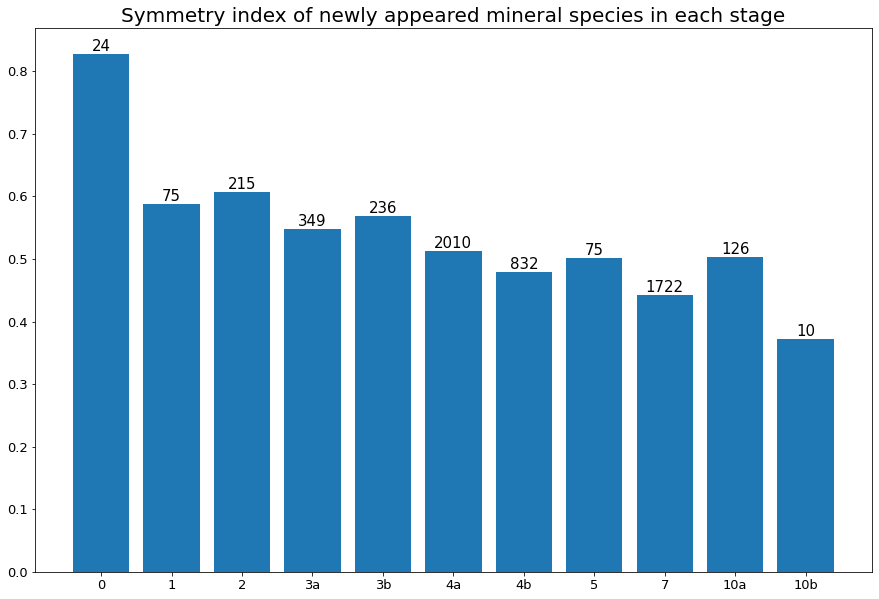

In [5]:
plt.figure(figsize=FIGSIZE)
bars = plt.bar(range(len(stages)), stage_symmetry_indices_appeared)
plt.xticks(range(len(stages)), labels=stages, fontsize=FS_TICK)
plt.yticks(fontsize=FS_TICK)
plt.title('Symmetry index of newly appeared mineral species in each stage', fontsize=FS_TITLE)

[ print(f'Stage {s}:\t {sym:.3f}') for s, sym in zip(stages, stage_symmetry_indices_appeared) ]

for n_minerals, bar in zip(n_minerals_appeared_in_stage, bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{n_minerals}',
             ha='center', va='bottom', fontsize=FS_SAMPLE
            )

plt.savefig('graph_first_appeared_yushkin.png')

Stage 0:	 0.903
Stage 1:	 0.720
Stage 2:	 0.691
Stage 3a:	 0.627
Stage 3b:	 0.635
Stage 4a:	 0.548
Stage 4b:	 0.552
Stage 5:	 0.624
Stage 7:	 0.448
Stage 10a:	 0.565
Stage 10b:	 0.510


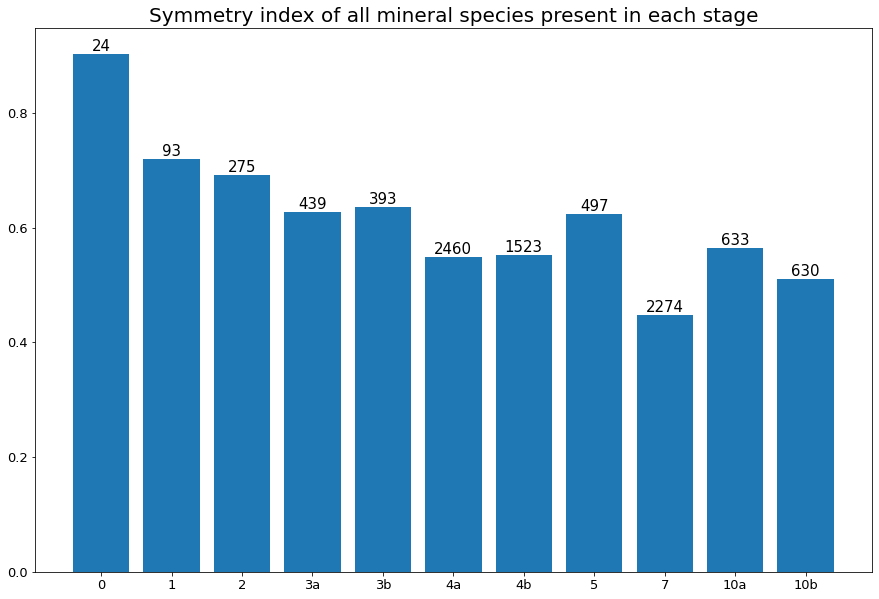

In [6]:
plt.figure(figsize=FIGSIZE)
bars = plt.bar(range(len(stages)), stage_symmetry_indices_present)
plt.xticks(range(len(stages)), labels=stages, fontsize=FS_TICK)
plt.yticks(fontsize=FS_TICK)
plt.title('Symmetry index of all mineral species present in each stage', fontsize=FS_TITLE)

[ print(f'Stage {s}:\t {sym:.3f}') for s, sym in zip(stages, stage_symmetry_indices_present) ]

for n_minerals, bar in zip(n_minerals_present_in_stage, bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{n_minerals}',
             ha='center', va='bottom', fontsize=FS_SAMPLE
            )
    
plt.savefig('graph_present_yushkin.png')

Stage 0:	 0.827
Stage 1:	 0.646
Stage 2:	 0.619
Stage 3a:	 0.582
Stage 3b:	 0.579
Stage 4a:	 0.533
Stage 4b:	 0.521
Stage 5:	 0.520
Stage 7:	 0.496
Stage 10a:	 0.496
Stage 10b:	 0.496


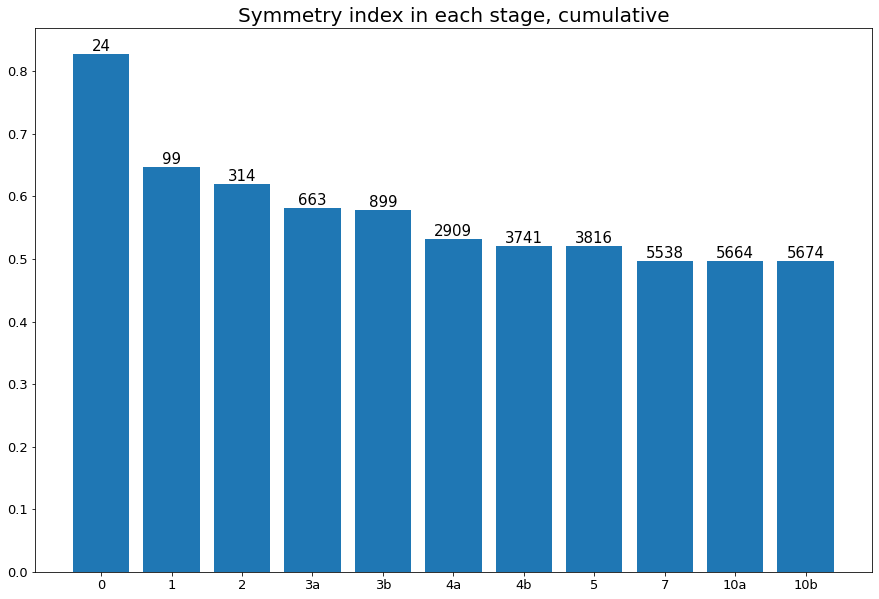

In [7]:
plt.figure(figsize=FIGSIZE)
bars = plt.bar(range(len(stages)), stage_symmetry_indices_cumulative)
plt.xticks(range(len(stages)), labels=stages, fontsize=FS_TICK)
plt.yticks(fontsize=FS_TICK)
plt.title('Symmetry index in each stage, cumulative', fontsize=FS_TITLE)

[ print(f'Stage {s}:\t {sym:.3f}') for s, sym in zip(stages, stage_symmetry_indices_cumulative) ]

for n_minerals, bar in zip(n_species_cumulative, bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{n_minerals}',
             ha='center', va='bottom', fontsize=FS_SAMPLE
            )
    
plt.savefig('graph_cumulative_yushkin.png')

In [8]:
s = stage_symmetry_indices_cumulative
n = n_minerals_appeared_in_stage

symmetry_index_change_per_species = np.array([ (s[i+1] - s[i])/n[i] for i in range(0, len(stages)-1) ])
del s, n

stage_transitions = [ f'{stages[i]}-{stages[i+1]}' for i in range(0, len(stages)-1) ]

for s, sc in zip(stage_transitions, symmetry_index_change_per_species):
    print(f'Stage {s}:\t {sc:+.2e}')

Stage 0-1:	 -7.54e-03
Stage 1-2:	 -3.64e-04
Stage 2-3a:	 -1.73e-04
Stage 3a-3b:	 -9.76e-06
Stage 3b-4a:	 -1.95e-04
Stage 4a-4b:	 -5.90e-06
Stage 4b-5:	 -4.66e-07
Stage 5-7:	 -3.21e-04
Stage 7-10a:	 +9.33e-08
Stage 10a-10b:	 -1.75e-06


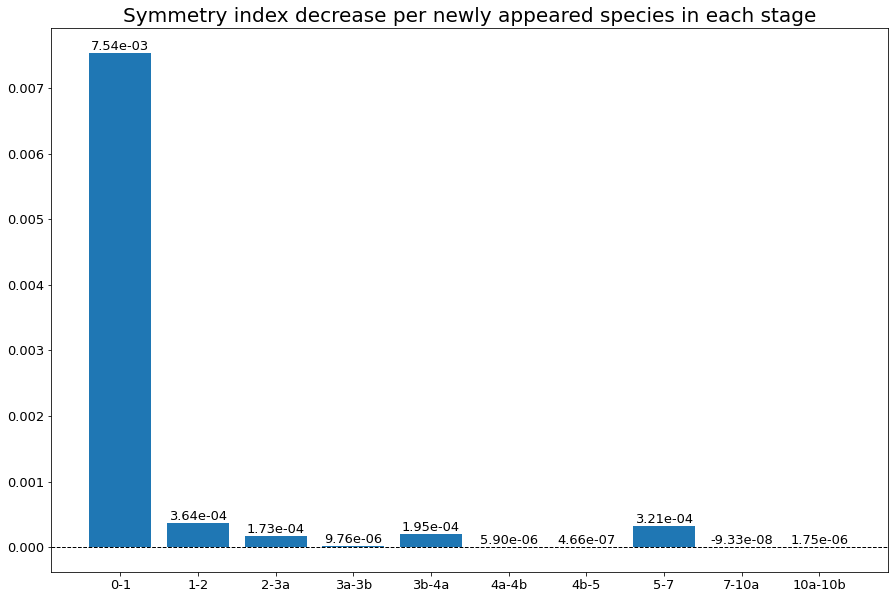

In [9]:
plt.figure(figsize=FIGSIZE)
bars = plt.bar(range(len(stages)-1), -symmetry_index_change_per_species)
plt.xticks(range(len(stages)-1), labels=stage_transitions, fontsize=FS_TICK)
plt.yticks(fontsize=FS_TICK)
plt.title('Symmetry index decrease per newly appeared species in each stage', fontsize=FS_TITLE)

plt.axhline(0, c='k', ls='--', lw=1)
for sc, bar in zip(symmetry_index_change_per_species, bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{-sc:.2e}',
             ha='center', va='bottom', fontsize=13
            )
    
plt.savefig('graph_decrease_per_species_yushkin.png')

<ipython-input-10-3e7cb3551668>:2: RuntimeWarning: invalid value encountered in log10
  bars = plt.bar(range(len(stages)-1), np.log10(-symmetry_index_change_per_species))
posx and posy should be finite values
posx and posy should be finite values


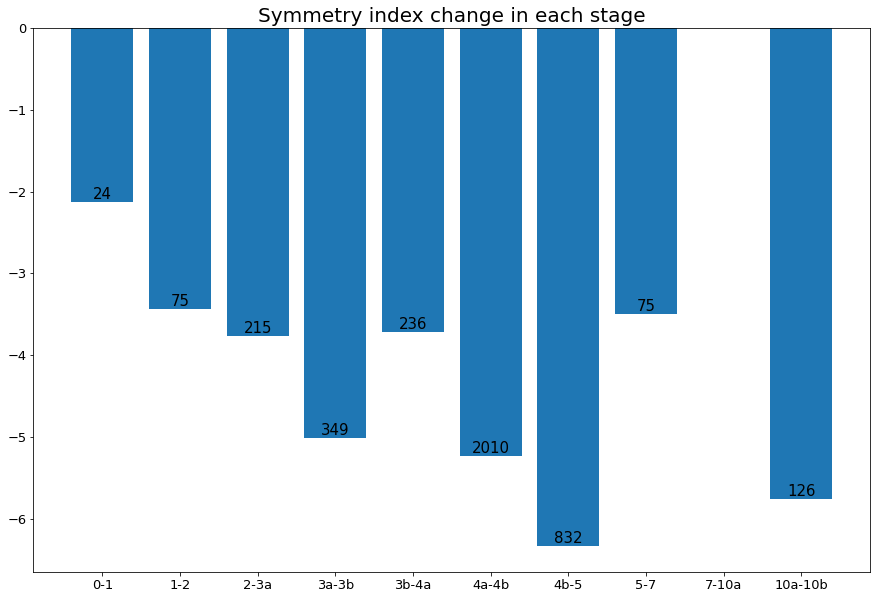

In [10]:
plt.figure(figsize=FIGSIZE)
bars = plt.bar(range(len(stages)-1), np.log10(-symmetry_index_change_per_species))
plt.xticks(range(len(stages)-1), labels=stage_transitions, fontsize=FS_TICK)
plt.yticks(fontsize=FS_TICK)
plt.title('Symmetry index change in each stage', fontsize=FS_TITLE)

for n_minerals, bar in zip(n_minerals_appeared_in_stage, bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{n_minerals}',
             ha='center', va='bottom', fontsize=FS_SAMPLE
            )